In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="../../css/custom.css">

# Tuning Neural Networks


![footer_logo](../../images/logo.png)

## Goal

- Solve a practical problem from scratch
- Familiarize yourself with advanced settings and parameter tunings

## Program
- [The dataset]()
- [Building a simple neural network]()
- [Improving a model]()
- [Building a better neural network]()
- [Grid search for neural networks]()


In [2]:
import inspect
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.insert(0, '../')

%matplotlib inline
plt.rcParams["figure.figsize"] = 15, 6

---
## The Churn Dataset

We will use a dataset containing customer information and whether they stopped being a customer with the bank.

In [3]:
dataset = pd.read_csv('../../data/Churn_Modelling.csv')

print(dataset.shape)
dataset.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Before we can start

- Separate relevant features and the target variable
- Convert categorical variables
- Feature Scaling

In [4]:
X = dataset.iloc[:, 3:-1].values
y = dataset.iloc[:, -1].values

In [5]:
X.shape

(10000, 10)

For variable encoding we will use some preprocessing tools from *sklearn library*:

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#encoding genders
labelencoder = LabelEncoder()
X[:, 2] = labelencoder.fit_transform(X[:, 2])
X.shape

(10000, 10)

Now we need to replace 3 country categories with 2 dummy variables:

In [7]:
dataset['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [8]:
#creating dummies for each country
from sklearn.compose import ColumnTransformer 

ct = ColumnTransformer([("onehot", OneHotEncoder(drop='first'),[1])], remainder="passthrough") # The arg ([1]) is the list of columns we want to transform in this step
X = ct.fit_transform(X)
X.shape

(10000, 11)

### Feature Scaling

Before we can scale the features, we need to perform the train-test split.

**(!)** We need to make sure that no information from the test set leaks into the train set

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [10]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) #note here how the scaler is fit only on the train set

---
## Building a simple Neural Network

Remember that it is always good to start small and see what performance we can achieve with a relatively simple model. A Neural Network with two hidden layers is a good starting point.

Choosing the right number of nodes in the hidden layers is always a matter of trial and error. However, there is a rule of thumb that often gives good results: *taking the number of nodes as the average between the number of inputs and the outputs of our NN*. In this case we have 11 inputs and 1 output, so (11+1)/2 = 6

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [12]:
def make_model_1(m_name):
    
    model = Sequential(name=m_name)
    model.add(layers.Dense(name="FullyConnected_1", units=6, activation="relu", input_dim=11))
    model.add(layers.Dense(name="FullyConnected_2", units=6, activation="relu"))
    model.add(layers.Dense(name="FullyConnected_OutputLayer", units=1, activation="sigmoid"))
    
    return model

model = make_model_1("SimpleModel")
model.summary()

Model: "SimpleModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FullyConnected_1 (Dense)    (None, 6)                 72        
                                                                 
 FullyConnected_2 (Dense)    (None, 6)                 42        
                                                                 
 FullyConnected_OutputLayer   (None, 1)                7         
 (Dense)                                                         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
np.random.seed(11)

model.fit(
    X_train,
    y_train,
    batch_size=10,
    epochs=15,
    verbose=0,
)
score = model.evaluate(X_test, y_test, verbose=0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.38686567544937134
Test accuracy: 0.840499997138977


How good is actually this test accuracy? Let's have a look at the target variable's class proportions:

In [15]:
dataset['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

79.6% of people did not exit. This means that if we would simply predict everyone to not exit, we would be right in 79.6% cases! This is an important benchmark.

Let's also have a look at the confusion matrix:

In [16]:
y_pred = model.predict(X_test)

y_pred = (y_pred > 0.5) #returns a Boolean for each value!

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm/cm.sum()


array([[0.763 , 0.031 ],
       [0.1285, 0.0775]])

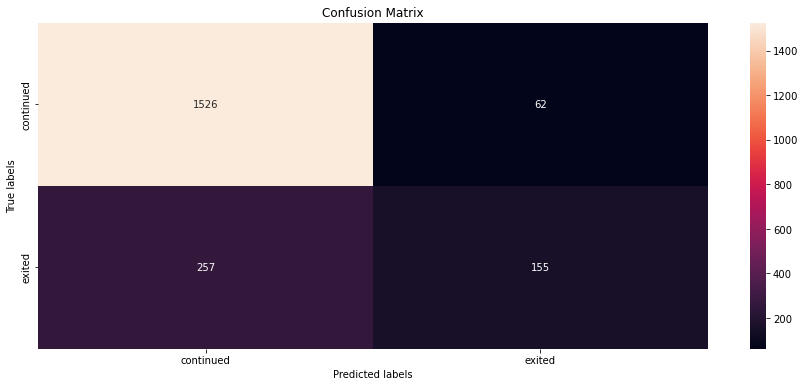

In [17]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['continued', 'exited']); ax.yaxis.set_ticklabels(['continued', 'exited']);

---
## Improving a model

The first model relied on a relatively simple structure and default parameters. 

    Which model parameters can we set differently to try improving performance?
    
Let's consider a number of such parameters, how to change them and what consequences it may have.

### Hidden layers and nodes

By increasing the number of hidden layers and nodes in each layer, we can allow our model to capture more complex relationships. At the same time we are risking getting more overfitting and more computational costs, so we should still be cautious with these.

Extra hidden layers can be simply added using `model.add(layers.Dense(...`, and the number of nodes is the correspondent `units=` parameter.

### Dropouts

Dropouts have became one of the most popular regularization options. It is usually a good idea to use them for each layer other than the output layer. The dropout percentage may be however hard to choose. Usually values between 0.1 and 0.5 could be used.

We can simply add Dropouts by adding `model.add(layers.Dropout())` after each relevant layer

### Different activation functions

`leaky relu` activation function can take care of the lack of learning when the current weights lock us out in relu's flat part. We can simply [change this](https://keras.io/activations/) by tuning relu's `alpha` parameter. 

`tanh` activation function can allow us to capture more symmetrical effects and output zero on average, which sometimes helps convergence.

Both of these options are however more computationally expensive than `relu`

### Weight initialization

We can change the way the weights are initialized to speed up convergence and avoid local minima. This setting is changed using `kernel_initializer` option for each layer. Note that By default Keras already uses `glorot_uniform` kernel_initializer. We can alternatively use `he_uniform`, which sometimes works better with `relu` activation functions. See the full list of possible [kernel initializers here](https://keras.io/initializers/)

### Early Stopping

Stop training when performance on validation data starts increasing. Simple, yet very effective

In Keras this can be achieved by adding `EarlyStopping(monitor='val_loss')` into the `callbacks=[]` option of the `model.fit()` step.

### Optimizers

`adam` has shown to be one of the best optimizers in many situations. In some cases however we may want to experiment and use `optimizer='rmsprop'` and `optimizer='nadam'`

### Batch size and Epochs

Fitting the model over more epochs can ensure that we do not stop too early (loss still decreasing). Too many epochs however often result in overfitting.

Batch size is usually chosen between 10 and 256 (often as powers of 2), and can be experimented with. The size of the dataset matters for it as well, with smaller datasets usually working better with smaller batch sizes.

---
## Building a better neural network

Now let's try to combine some of these settings to create a better neural network model:

In [18]:
np.random.seed(99)
from tensorflow.keras.layers import LeakyReLU

def make_model_2(m_name):
    
    model = Sequential(name=m_name)
    model.add(layers.Dense(name="FullyConnected_1", kernel_initializer='he_uniform', units=24, input_dim=11))
    model.add(layers.LeakyReLU(alpha=0.25))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(name="FullyConnected_2", units=12, activation="tanh"))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(name="FullyConnected_OutputLayer", units=1, activation="sigmoid"))
    
    return model

model2 = make_model_2("BetterModel")
model2.compile(optimizer='nadam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model2.summary()

Model: "BetterModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FullyConnected_1 (Dense)    (None, 24)                288       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 24)                0         
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 FullyConnected_2 (Dense)    (None, 12)                300       
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 FullyConnected_OutputLayer   (None, 1)                13        
 (Dense)                                                         
                                                       

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import time

To run Tensorboard use `tensorboard --logdir=tb/logs` in the terminal (make sure you are in the right directory, i.e. the one this notebook is located). After running it copy the provided link into your browser

In [20]:
np.random.seed(999)

es = EarlyStopping(monitor='val_loss', patience=2)

log_dir = os.path.join('tb/logs', f"run_{time.time()}")

model2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    verbose=0,
    callbacks=[es, TensorBoard(log_dir, write_graph=True)],
)
score2 = model2.evaluate(X_test, y_test, verbose=0)

print("Test loss:", score2[0])
print("Test accuracy:", score2[1])


Test loss: 0.3638656735420227
Test accuracy: 0.8535000085830688


This does not seem to be any better! Seems like making our model more complex has only hurt the test set performance. Perhaps a different / smarter set of parameters would do better?

---
## Grid search for neural networks

With so many parameters to choose from, how do we know which ones are the best? A good idea could be to try various parameters and select the combination that results in best performance. This can be achieved using Grid search. The number of parameters however should be chosen with caution as each extra parameter dimension may increase the number of models to train exponentially.

In [21]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#this allows using Keras classifiers inside sklearn!

from sklearn.model_selection import  GridSearchCV

In [22]:
def make_model_gs(optimizer, units_num, activation_type, third_layer=False):
    
    from tensorflow.keras.layers import Activation, Dense
    
    model = Sequential() 

    model.add(Dense(units=units_num, activation=activation_type, input_dim=11))

    model.add(Dense(units=units_num, activation=activation_type))
    
    if third_layer:
        model.add(Dense(units=units_num, activation=activation_type))
    
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    

    return model


#below we define how the classifier is fitted when called
model_gs = KerasClassifier(build_fn = make_model_gs)

C:\Users\651494\AppData\Local\Temp/ipykernel_11800/2763339097.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model_gs = KerasClassifier(build_fn = make_model_gs)


In [23]:
parameters= {'batch_size':[25,16],
             'epochs':[10, 30],
             'units_num':[6, 12],
             'activation_type':['relu', 'tanh'],
             'optimizer': ['rmsprop', 'adam']}

In [24]:
grid_search = GridSearchCV(estimator = model_gs,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3)

In [25]:
grid_search=grid_search.fit(X_train, y_train)

best_parameters=grid_search.best_params_
best_accuracy=grid_search.best_score_

Epoch 1/10
214/214 [==============================] - 1s 1ms/step - loss: 0.5693 - accuracy: 0.7834
Epoch 2/10
214/214 [==============================] - 0s 1ms/step - loss: 0.4945 - accuracy: 0.7986
Epoch 3/10
214/214 [==============================] - 0s 1ms/step - loss: 0.4733 - accuracy: 0.7986
Epoch 4/10
214/214 [==============================] - 0s 1ms/step - loss: 0.4593 - accuracy: 0.7986
Epoch 5/10
214/214 [==============================] - 0s 1ms/step - loss: 0.4478 - accuracy: 0.7986
Epoch 6/10
214/214 [==============================] - 0s 1ms/step - loss: 0.4383 - accuracy: 0.7988
Epoch 7/10
214/214 [==============================] - 0s 1ms/step - loss: 0.4298 - accuracy: 0.8044
Epoch 8/10
214/214 [==============================] - 0s 1ms/step - loss: 0.4228 - accuracy: 0.8104
Epoch 9/10
214/214 [==============================] - 0s 1ms/step - loss: 0.4154 - accuracy: 0.8183
Epoch 10/10
214/214 [==============================] - 0s 1ms/step - loss: 0.4060 - accuracy: 0.8221

In [ ]:
best_parameters

In [ ]:
best_accuracy

In [ ]:
#test accuracy
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

---
## Summary

- Tuning parameters of a deep learning model is really an art
- Luckily there are multiple heuristics that we can use to try to make our models better (or at least to not make them worse)
- Searching over a set of parameters to find the best ones is usually a better idea than trying to guess them yourself
- However, grid searches can be time consuming when working with deep learning models

In [ ]:
# remove tensorboard files
shutil.rmtree('tb')